In [240]:
import json, argparse, os
from turtle import width
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.widgets import Slider, TextBox
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.animation as animation
from matplotlib import markers, rcParams
import numpy as np
import seaborn as sns
plt.style.use("./tplot.mplstyle")

In [242]:
Ni=np.array([20, 30, 50, 75, 100, 120, 150])
modes=np.array([1,1,3,4,6,7,9])

#qs=modes*np.pi/Ni

natfreqs=np.array([0.638, 0.777, 0.725, 0.669, 0.725, 0.710, 0.716])
maxargs=np.array([83, 101, 94, 87, 94, 92, 94])

ab=10.0
t2=20.0
t3=50.0
b=1.0
a=10.0
l=1

omega0s = np.arange(0.01, 0.26, 0.005)

dts=np.ones_like(Ni)

instances=4

20
30
0.9599999999999999
50
75
100
120
150


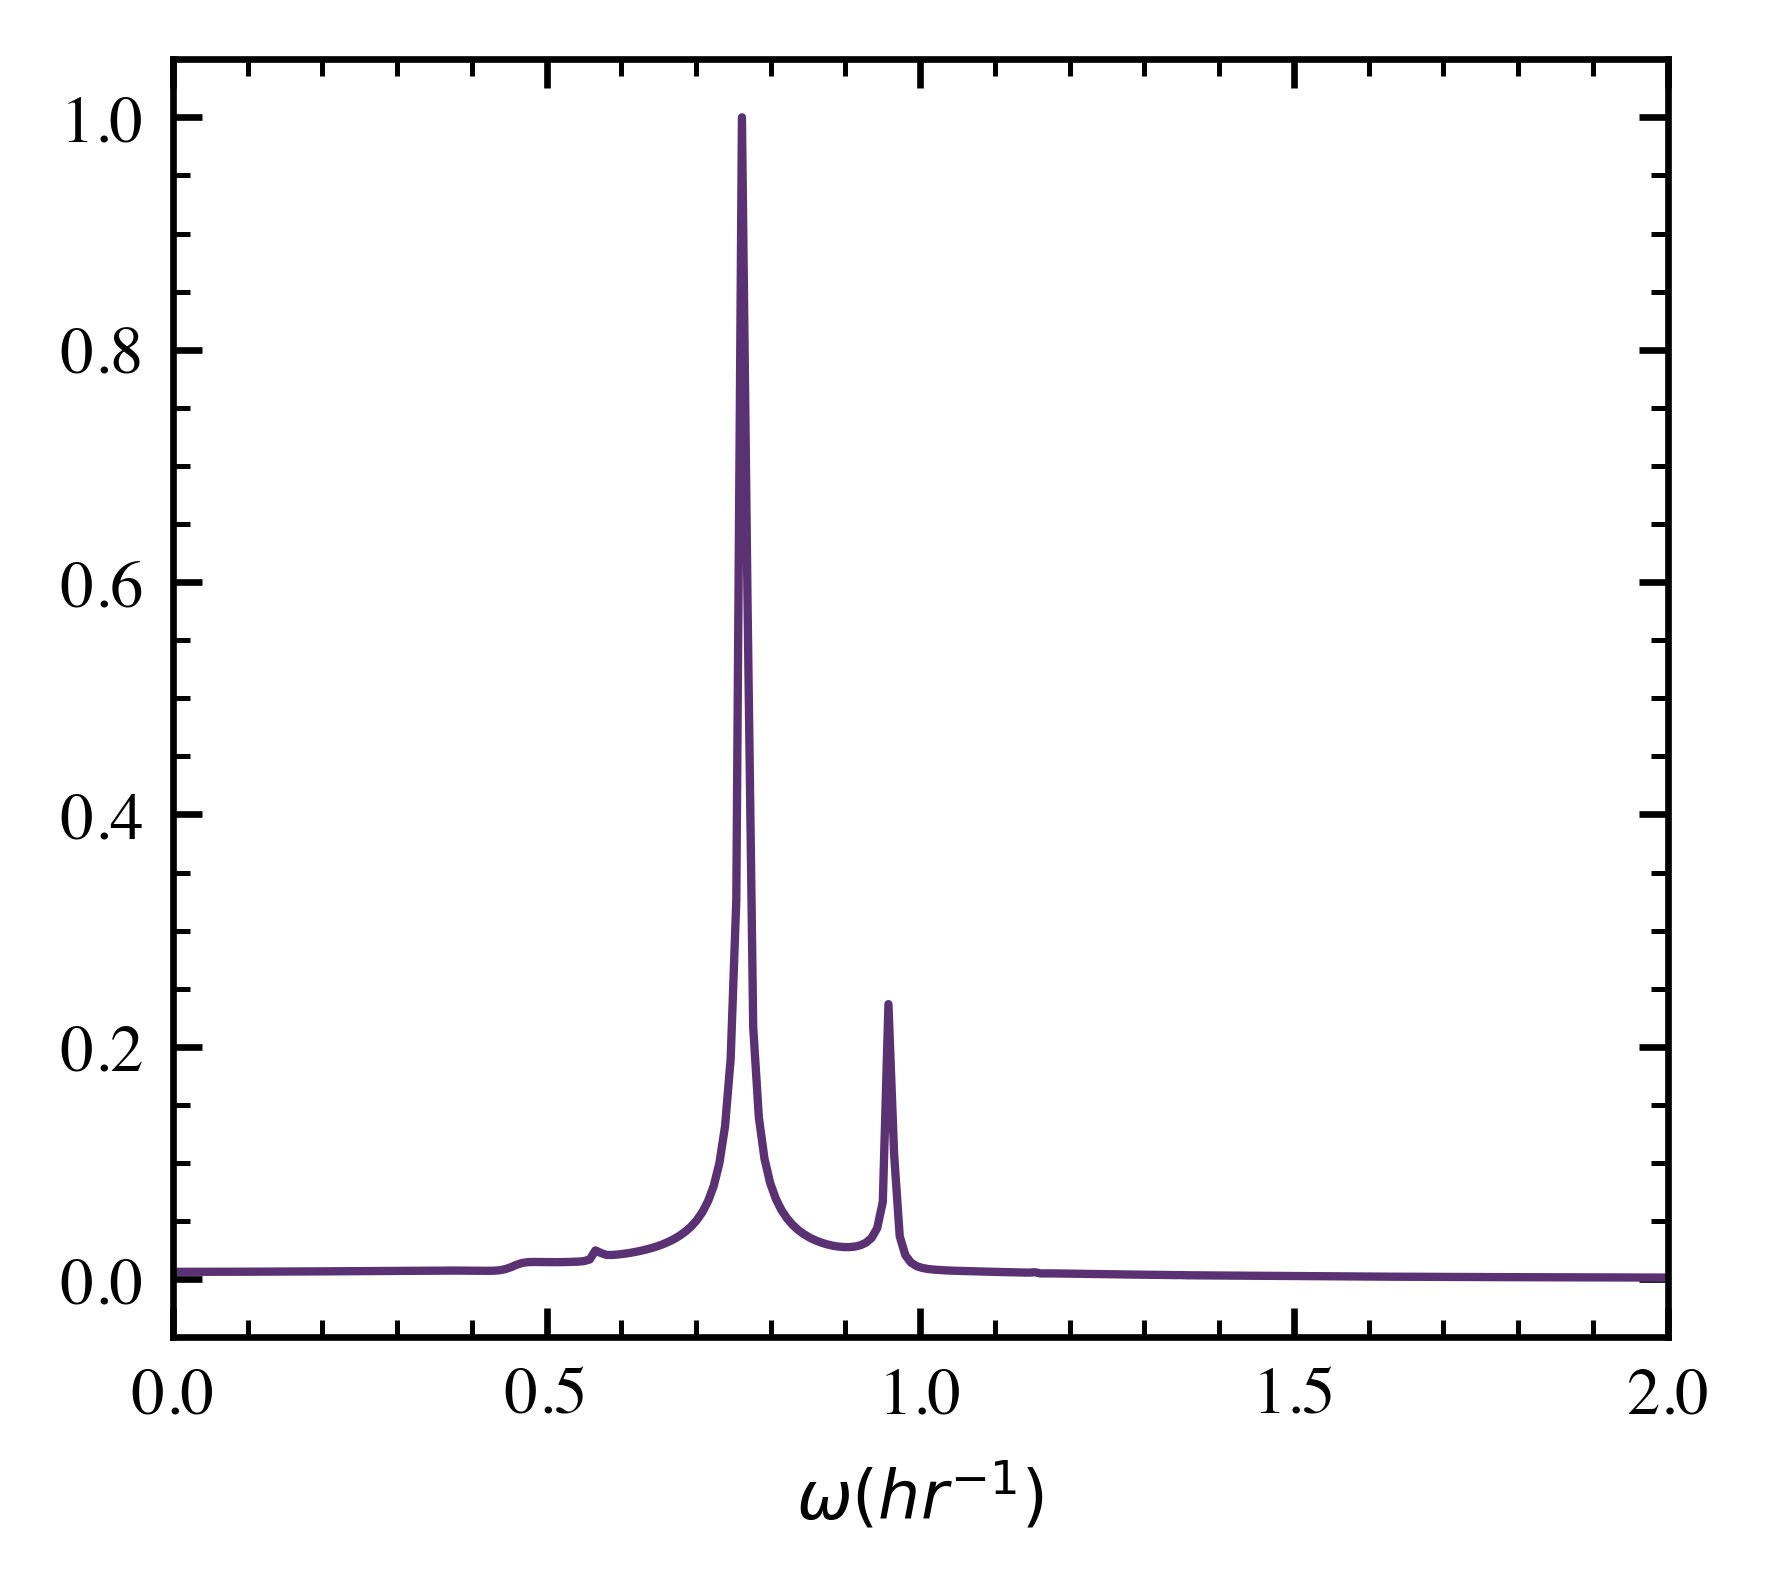

In [323]:
maxdispN=np.zeros((len(Ni), instances,len(omega0s)))
peaksN = np.zeros((len(Ni), instances, len(omega0s)))
j=0
for N in Ni:
	print(N)
	for ins in np.arange(instances):
		Sols=[]
		peaks=[]
		for omega0 in omega0s:
			Sols.append(np.fromfile("osc_strain_prop_disp/{:d}/{:1.1f}/{:1.1f}/{:1.1f}/solution_{:1.3f}_{:d}.dat".format(N, ab, t2, t3, omega0, ins)))
			Sols[-1]=Sols[-1].reshape(len(Sols[-1])//(3*N+1), 3*N+1)
			Sols[-1]=Sols[-1][:,:N+1]
    		#plt.show()
	
		#find the value of max amplitude for the last 50 timepoints
		Sols = np.asarray(Sols)
		#to find displacement, subtract each r_i from its original position
		displacement = Sols-np.arange(0,N+1,1)[np.newaxis,np.newaxis,:]
		#if (xmid[j]-int(xmid[j])) != 0: #if the number of cells is odd and there is no middle point, take avg of the two points in the middle
		#	displacement[:,:,int(xmid[j])] = (displacement[:,:,int(xmid[j])]+displacement[:,:,int(xmid[j]+1)])/2
		#xmax = np.argmax(np.max(displacement, axis=1),axis=1)
		dispfft = np.fft.rfft(displacement[:,:,-10], axis=1)
		omegafft = np.fft.rfftfreq(len(displacement[0,:,0]), dts[j])
		fftmags = abs(dispfft); 
		Ampfft = np.zeros_like(dispfft)
		peakpts = 10
		for i in np.arange(0,len(omega0s),1):
			index = np.argmax(fftmags[i])
			peaks.append(omegafft[index]*24*np.pi)

			index=maxargs[j]
			Ampfft[i,index-peakpts:index+peakpts+1] += dispfft[i,index-peakpts:index+peakpts+1]
			#plt.scatter(i+omegafft*24*np.pi,abs(fftmags[i]))
			#plt.xlim(0,30)
		#plt.show()
		idisplacement = np.fft.irfft(Ampfft, axis=1, n=len(displacement[0,:,0]))
		#from this maximum over all cells take maximum over all times
		maxdisplacement = np.max(idisplacement,axis=1)
		maxdisplacement /= np.max(maxdisplacement)
		maxdispN[j, ins]+=maxdisplacement
		peaksN[j,ins]+= peaks/natfreqs[j]
	if N==30:
			ploti= 14#4
			plt.plot(omegafft*12*2*np.pi, fftmags[ploti]/np.max(fftmags[ploti]), color='#5a3173')
			plt.xlim(0,2)
			plt.xlabel(r'$\omega (hr^{-1})$')
			print(omega0s[ploti]*12)
			plt.savefig('Figures/spectrum_N_30_omega_{:1.3f}.svg'.format(omega0s[ploti]*12))
	j+=1

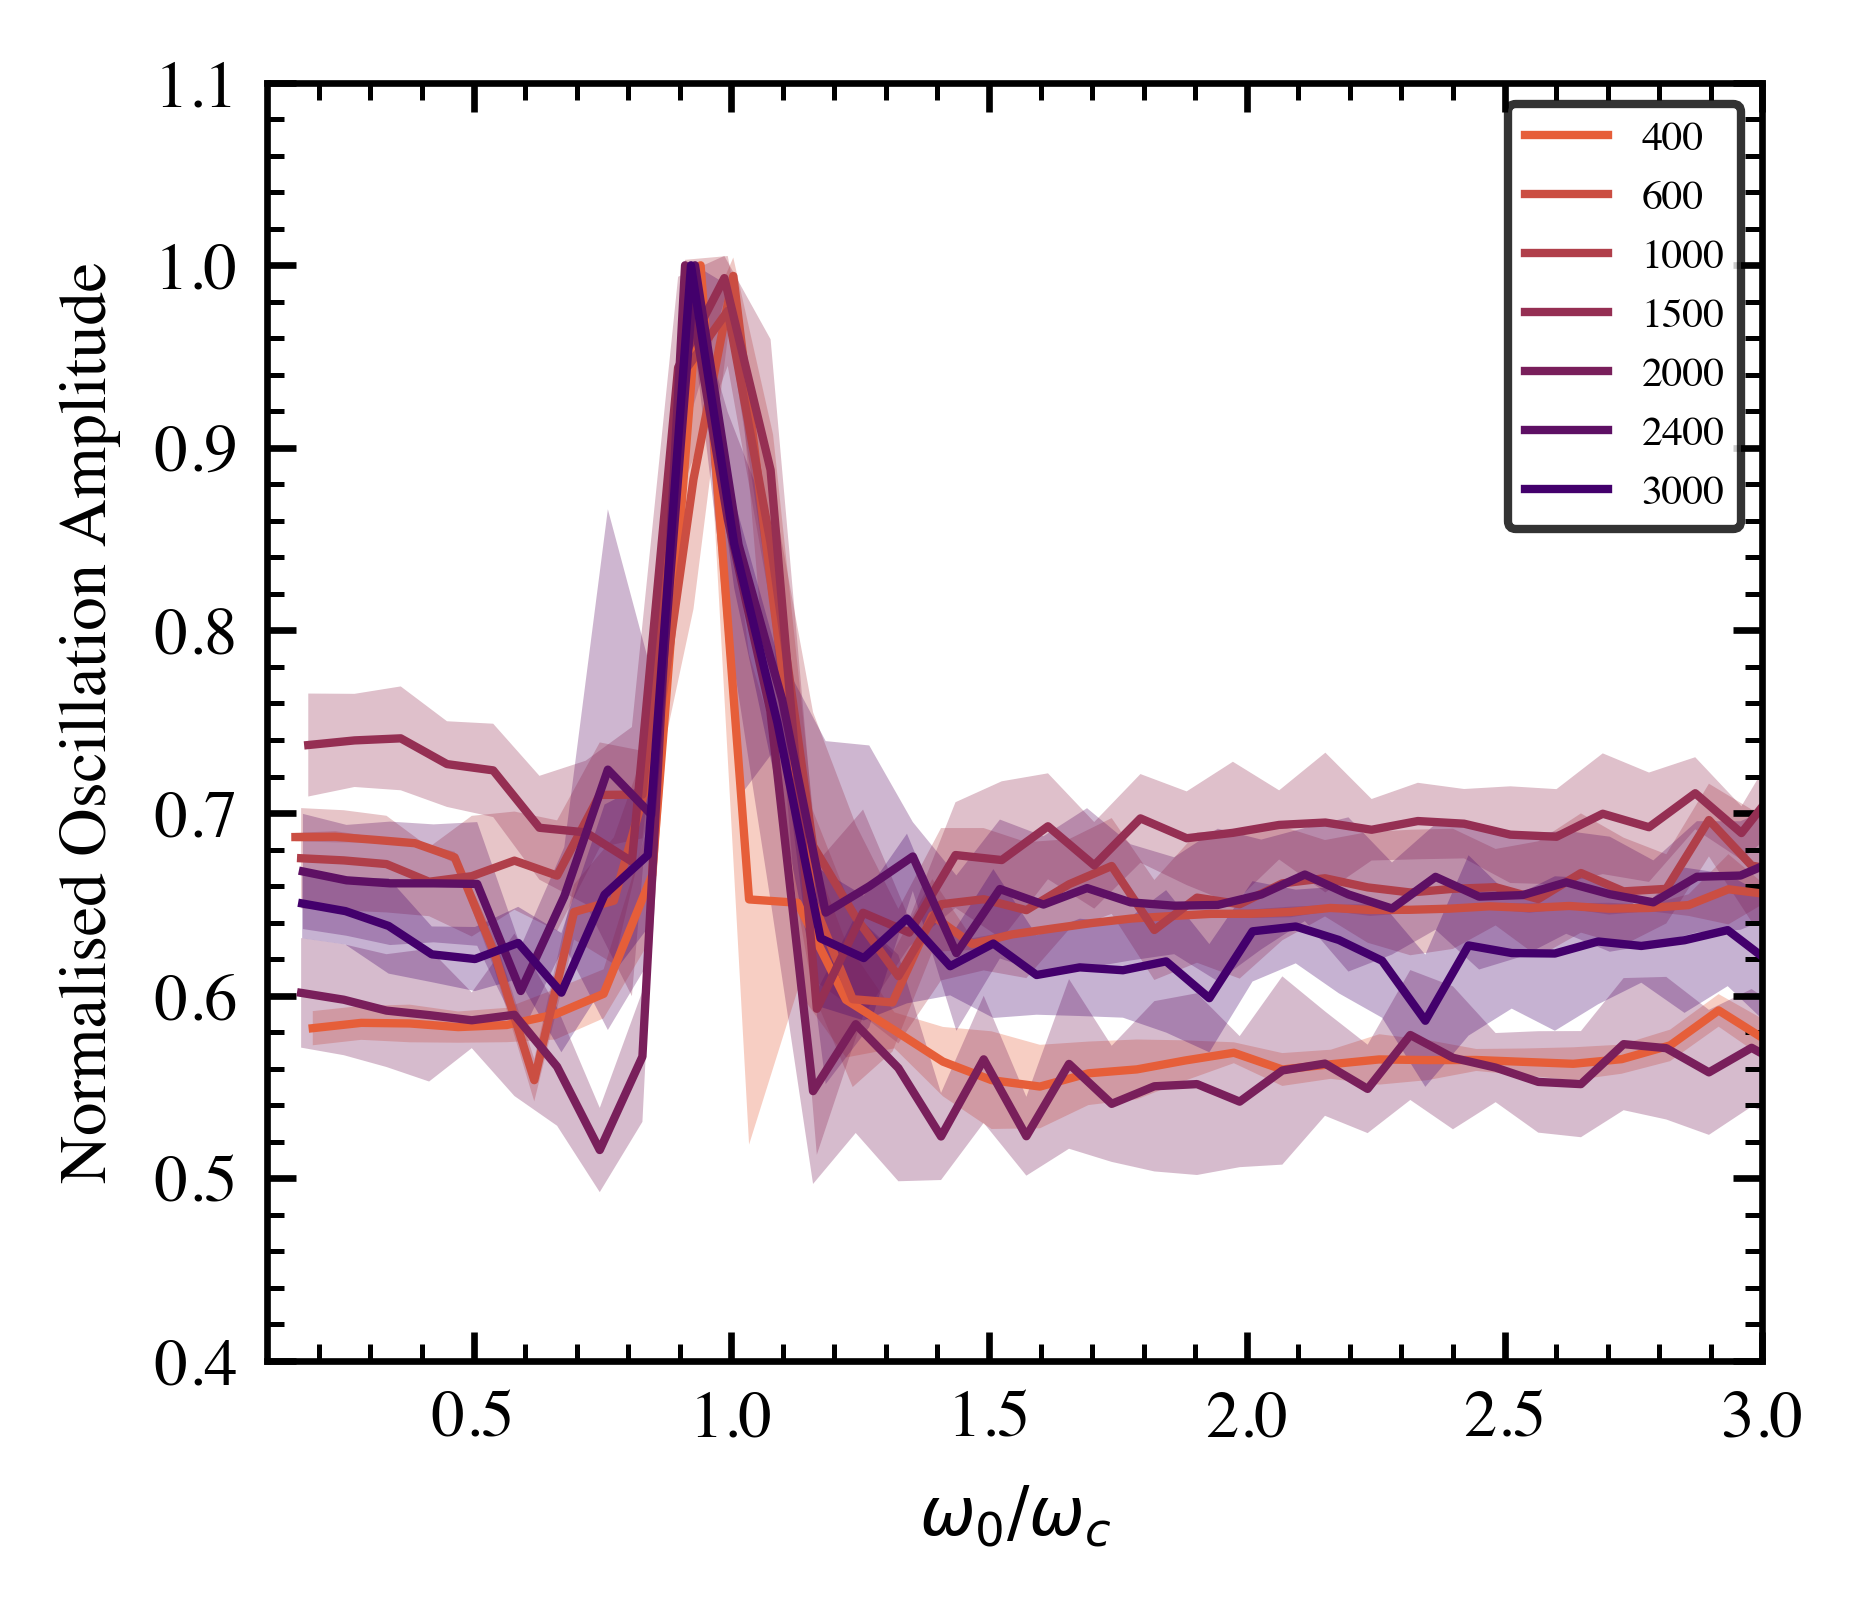

In [324]:
fig, ax = plt.subplots(1)
#C = ["#FA0C0C","#D00A0A","#A70808","#7D0606","#530404","#2A0202","#000000"]
C = ["#CC00A0","#AA1F8F","#883F7F","#665F6E","#447E5D","#229E4D","#00BD3C"]
C = ["#E65E39","#CB4E42","#B03F4A","#952F53","#791F5B","#5E1064","#43006C"]


for i in np.arange(0,len(Ni)):#[0,1,3,5,7]:
	if i!=30 and i!=50:
		x  = (omega0s*12/natfreqs[i])
		y  = np.mean(maxdispN[i], axis=0)
		y1 = np.mean(maxdispN[i], axis=0)+np.std(maxdispN[i], axis=0)
		y2 = np.mean(maxdispN[i], axis=0)-np.std(maxdispN[i], axis=0)
		ax.plot(x, y, label=(Ni[i]*20), color=C[i])#, marker='o', linestyle='')
		ax.fill_between(x, y1, y2, color=C[i], alpha=0.3, edgecolor='none')
		#ax[1].plot(1/Ni[i], np.min(maxdispN[i]), marker='o')
	    #plt.axvline(x=natfreqs[i], linestyle='dashed', color='black')
ax.set_xlabel(r'$\omega_{ext}/\omega_{nat}$')
ax.set_xlabel(r'$\omega_{0}/\omega_{c}$')
ax.set_ylabel('Normalised Oscillation Amplitude')
ax.set_xlim(0.1,3)
legend=plt.legend(prop={'size':5})
legend.get_frame().set_edgecolor('0.0')
#legend.get_frame().set_boxstyle('')
plt.ylim(0.4,1.1)
plt.savefig('Figures/resonance_plot.svg')
plt.show()

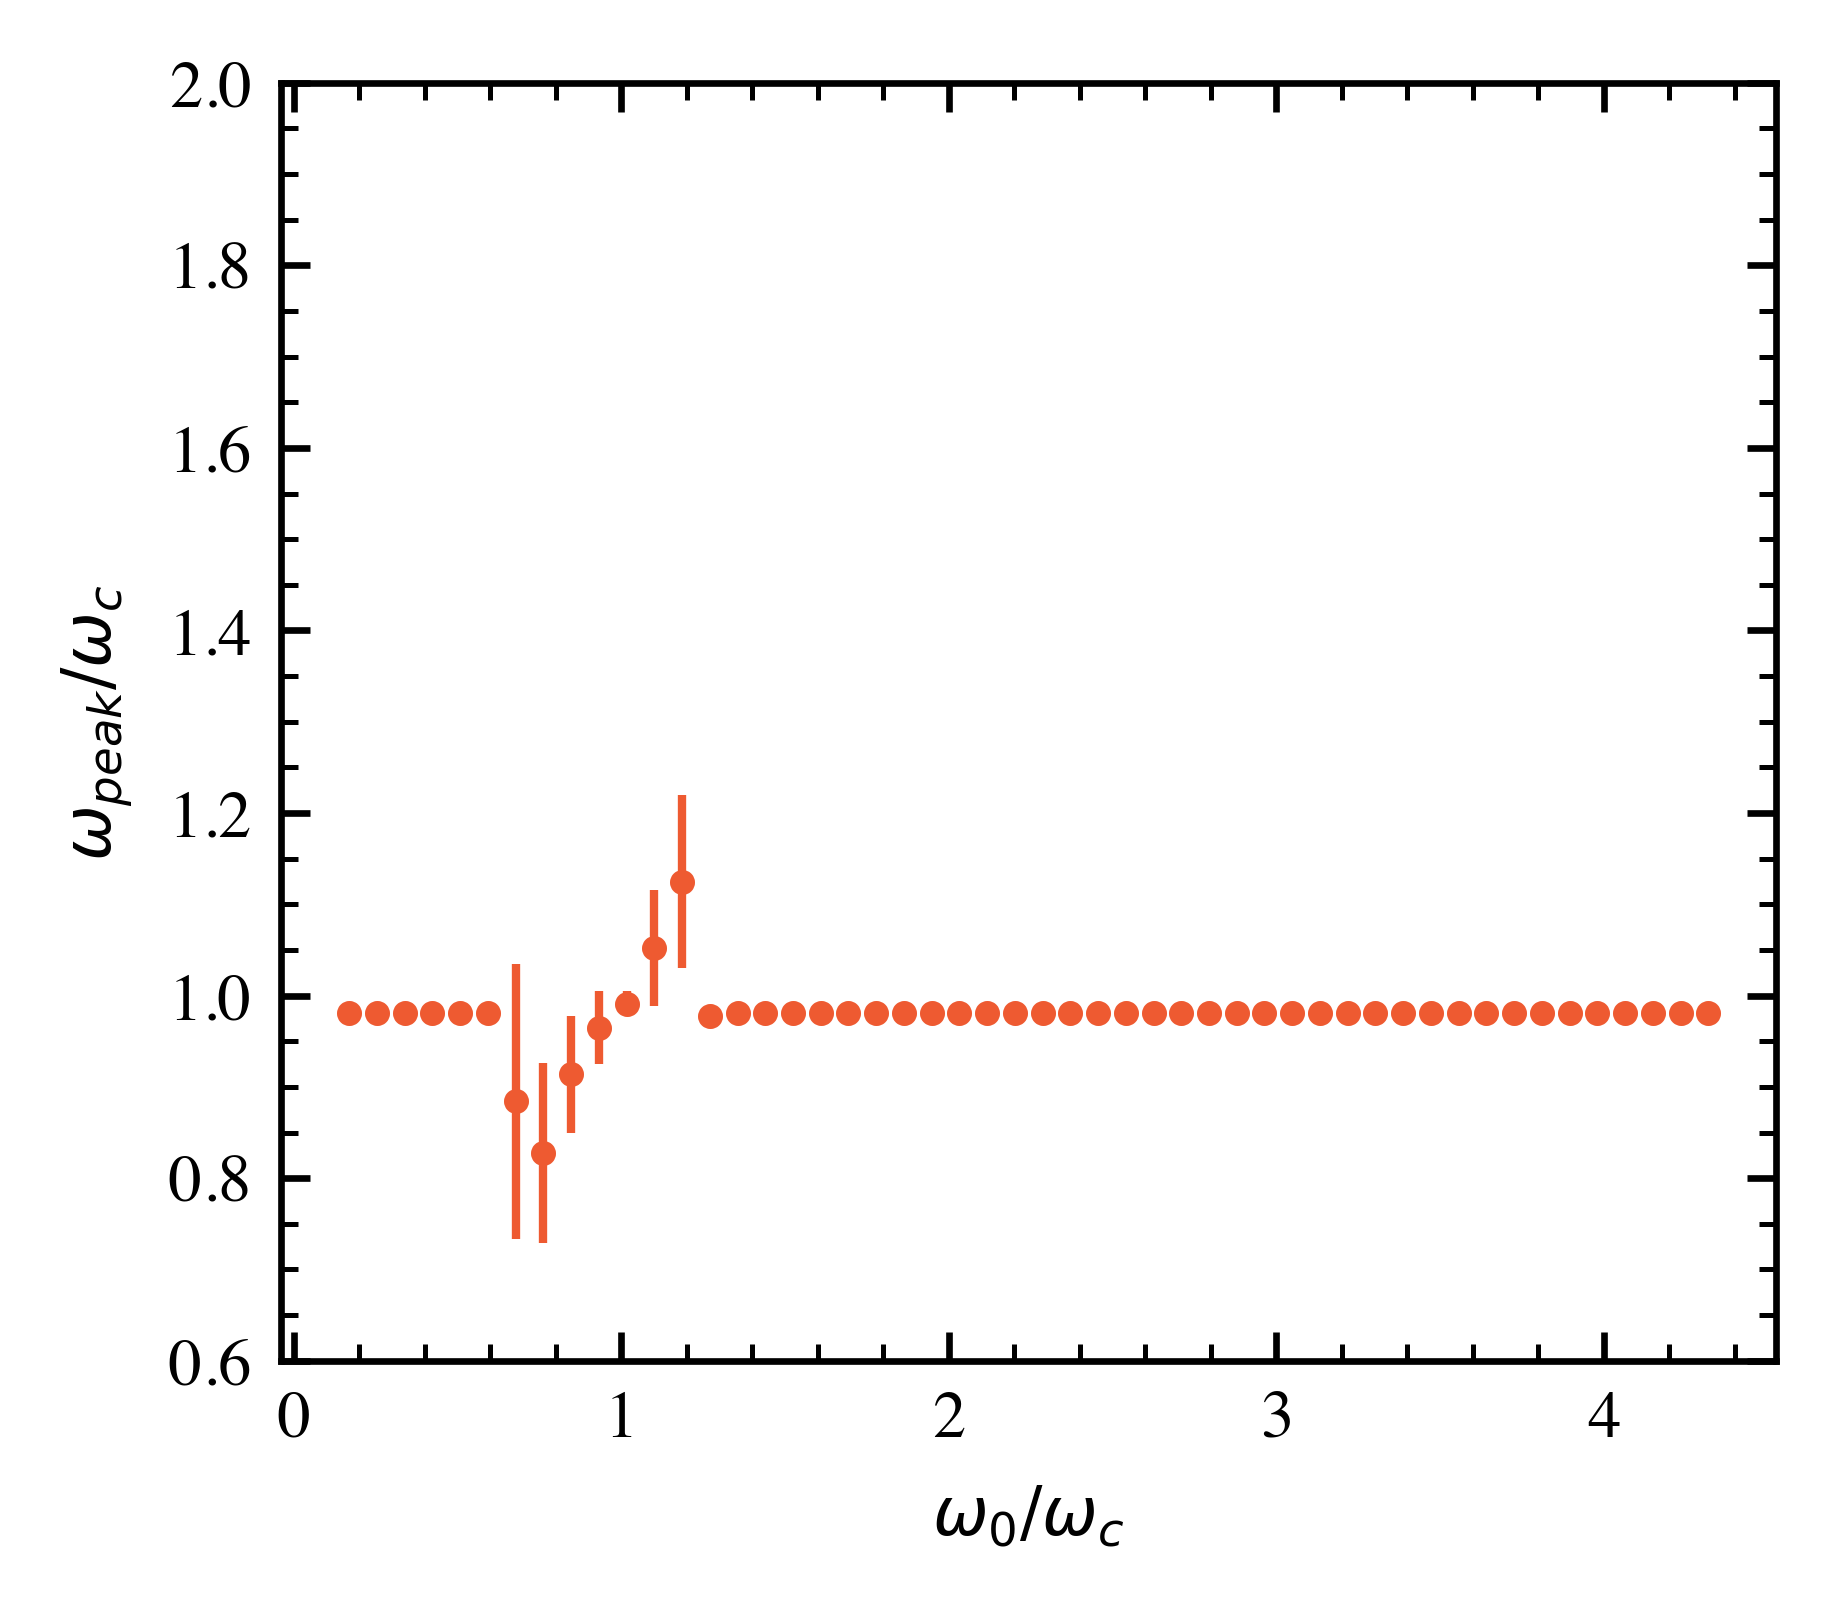

In [327]:
peaksNf = peaksN.reshape(len(Ni)*instances, len(omega0s))
plt.errorbar(omega0s*12/np.mean(natfreqs),np.mean(peaksNf,axis=0),yerr=np.std(peaksNf,axis=0),marker='o',linestyle='', color= '#ee5a31', markersize='2')
plt.ylim(0.6,2)
plt.xlabel(r'$\omega_0/\omega_c$')
plt.ylabel(r'$\omega_{peak}/\omega_{c}$')
plt.savefig('Figures/peaks_at_natural_freqs.svg')

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 47]
[ 1  2  3  3  4  5  6  6  7  8  9 10 10 11 12 13 13 14 15 16 16 17 18 19
 20 20 21 22 23 23 24 25 26 27 27 28 29 30 30 31 32 33 33 34 35 36 37 37
 38 39]
[ 1  2  3  4  4  5  6  7  8  9  9 10 11 12 13 14 14 15 16 17 18 19 19 20
 21 22 23 24 24 25 26 27 28 28 29 30 31 32 33 33 34 35 36 37 38 38 39 40
 41 42]
[ 1  2  3  4  5  6  7  8  8  9 10 11 12 13 14 15 16 17 17 18 19 20 21 22
 23 24 25 26 26 27 28 29 30 31 32 33 34 34 35 36 37 38 39 40 41 42 43 43
 44 45]
[ 1  2  3  4  4  5  6  7  8  9  9 10 11 12 13 14 14 15 16 17 18 19 19 20
 21 22 23 24 24 25 26 27 28 28 29 30 31 32 33 33 34 35 36 37 38 38 39 40
 41 42]
[ 1  2  3  4  5  5  6  7  8  9 10 10 11 12 13 14 15 16 16 17 18 19 20 21
 21 22 23 24 25 26 27 27 28 29 30 31 32 32 33 34 35 36 37 38 38 39 40 41
 42 43]
[ 1  2  3  4  5  5  6  7  8  9 10 10 11 12 13 14 15 15 16 17 18 19 20 20
 21

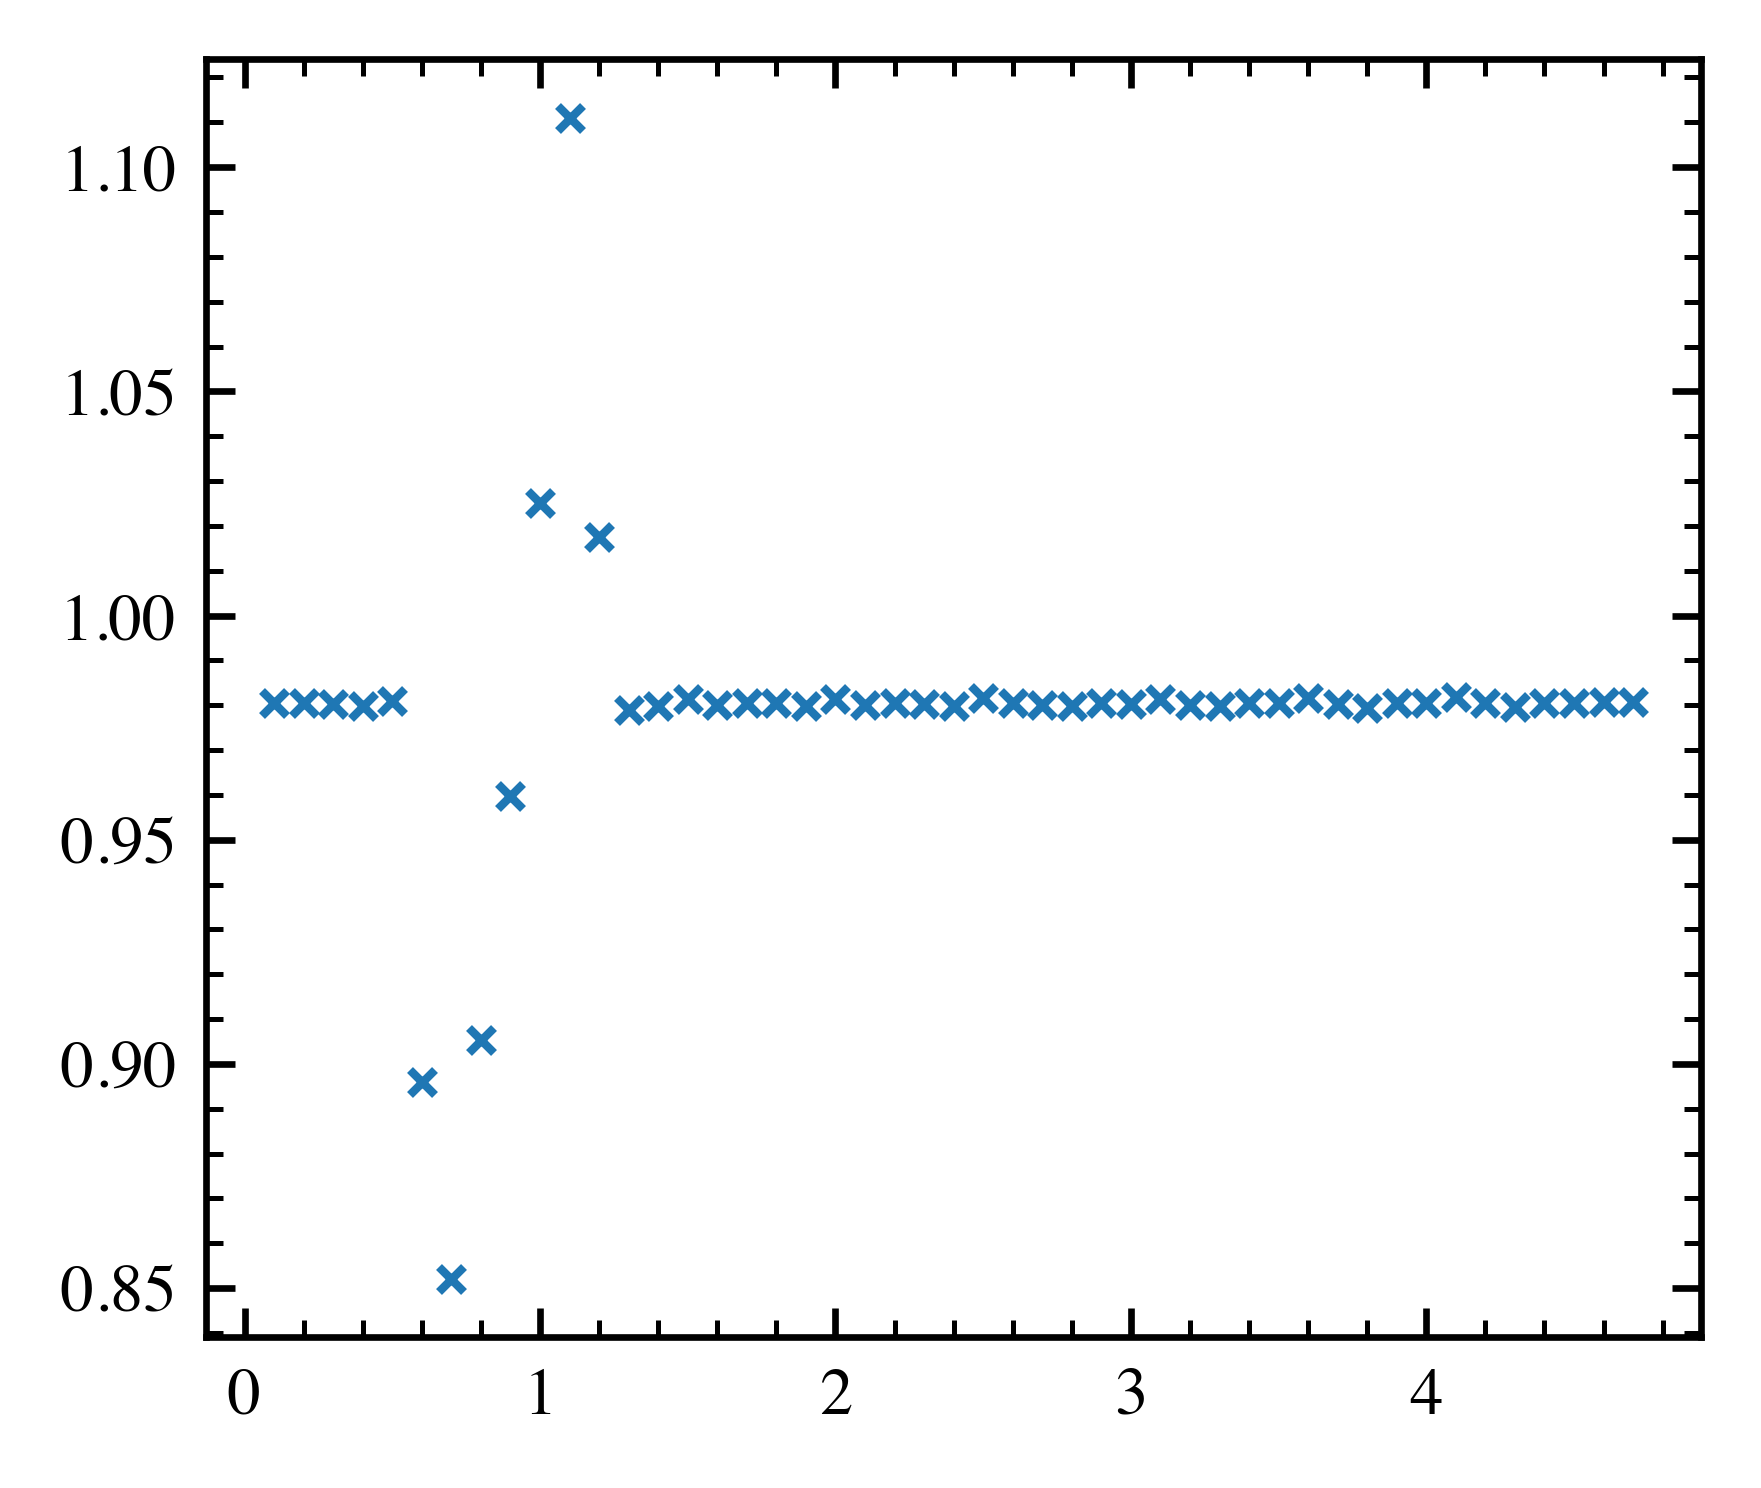

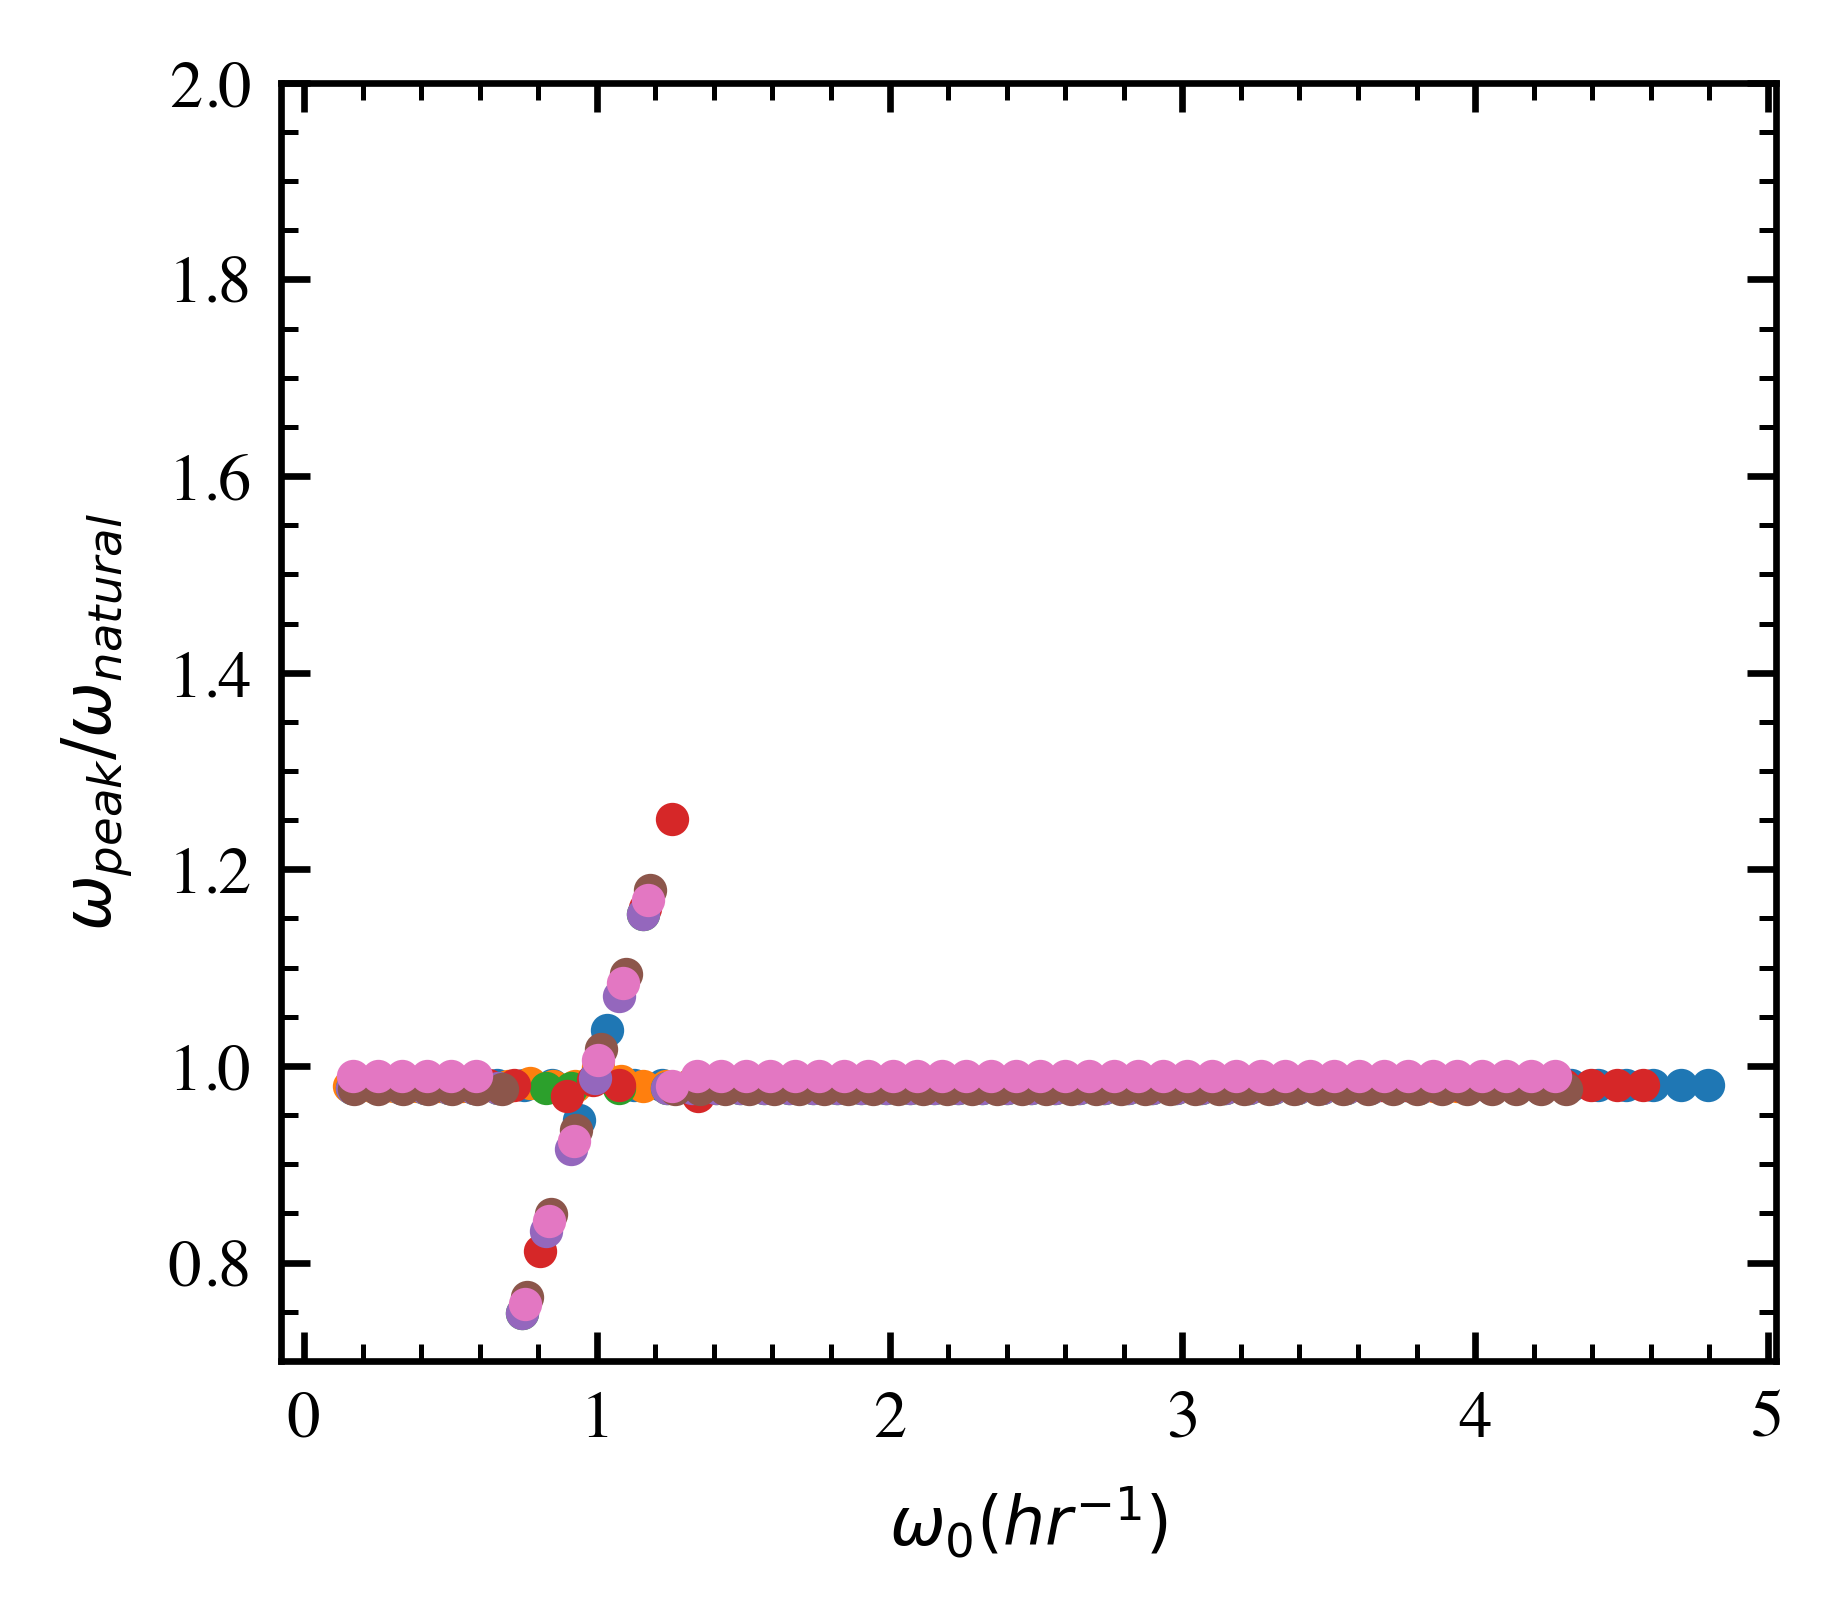

In [281]:
binedges = np.arange(0, 4.8, 0.1)
bins = np.zeros_like(binedges)
binnumber = np.zeros_like(binedges)
for n in np.arange(len(Ni)):
    indices = np.int32(10*(omega0s*12/natfreqs[n]))  #this is the bin number
    print(indices)
    for o in np.arange(len(omega0s)):
        for ins in np.arange(instances):
            bins[indices[o]]+=peaksN[n, ins, o]
            binnumber[indices[o]]+=1
print(bins)
bins = bins[1:]/binnumber[1:]
plt.plot(binedges[1:], bins, marker='x', linestyle='')
plt.show()
for n in np.arange(len(Ni)):
    plt.errorbar(omega0s*12/natfreqs[n],np.mean(peaksN[n],axis=0),yerr=np.std(peaksN[n],axis=0),marker='o',linestyle='')
#plt.xlim(0.1,1)
plt.ylim(0.7,2)
plt.xlabel(r'$\omega_0(hr^{-1})$')
plt.ylabel(r'$\omega_{peak}/\omega_{natural}$')


In [13]:
peaksN

array([[0.76581687, 0.76581687, 0.76581687, 0.76581687, 0.76581687,
        0.71844676, 0.76581687, 0.76581687, 0.76581687, 0.76581687,
        0.76581687, 0.76581687, 0.76581687, 0.76581687, 0.76581687,
        0.76581687, 0.76581687, 0.76581687, 0.75792185, 0.76581687,
        0.76581687, 0.76581687, 0.76581687, 0.76581687, 0.76581687,
        0.76581687],
       [0.63160154, 0.63160154, 0.63160154, 0.63160154, 0.60002147,
        0.63160154, 0.63160154, 0.63160154, 0.63160154, 0.63160154,
        0.63160154, 0.63160154, 0.63160154, 0.63160154, 0.63160154,
        0.63160154, 0.63160154, 0.63160154, 0.63160154, 0.63160154,
        0.63160154, 0.63160154, 0.63160154, 0.63160154, 0.63160154,
        0.63160154],
       [0.76581687, 0.76581687, 0.76581687, 0.76581687, 0.76581687,
        0.76581687, 0.76581687, 0.76581687, 0.76581687, 0.76581687,
        0.76581687, 0.76581687, 0.76581687, 0.76581687, 0.76581687,
        0.76581687, 0.76581687, 0.76581687, 0.76581687, 0.76581687,
      